<img src="img/banner.png" width = 90%>


## Transfer Learning : classification d’images médicales à partir de modèles pré-entraînés de type CNN.

Projet de mise en place d'un système de classification binaire permettant de détecter des cas de pneumonie à partir de radios thoraciques, via utilisation d'un *modèle de vision par ordinateur préentraîné* type *CNN*. Utilisation du dataset *Chest X-Ray Pneumonia*.

Appréhension d'une démarche de suivi des expérimentations par *MLflow*, afin de tracer les paramètres d’entraînement, les métriques de performance et les versions de modèle.

**Contexte du projet** : Une équipe médicale souhaite tester l’apport de l’intelligence artificielle dans le diagnostic automatisé de la pneumonie à partir de radios thoraciques. Elle a besoin d’un prototype fonctionnel (Proof of Concept) permettant de démontrer la faisabilité d’un système de classification binaire d’images médicales.

_______________________________________________________________________________________________________________________________________________________

### Import des bibliothèques

In [29]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121   # DenseNet121 = modèle choisi, très utilisé dans le médical pour le détection
                                                        # de maladies pulmonaires
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import mlflow

np.set_printoptions(linewidth=np.inf)
np.set_printoptions(edgeitems=30)

# 1. Exploration des données

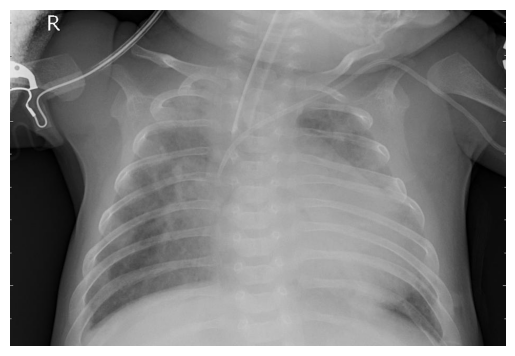

Shape (dimensions) : (640, 944, 3)
Type des valeurs : uint8


In [7]:
img = cv2.imread("data/test/PNEUMONIA/person1_virus_6.jpeg", cv2.IMREAD_COLOR_RGB)

plt.imshow(img)
plt.axis("off")
plt.show()

print(f"Shape (dimensions) : {img.shape}")
print(f"Type des valeurs : {img.dtype}")

En testant l'affichage de plusieurs images et leurs dimensions, nous pouvons voir que les radios sont de formats différents.

_______________________________________________________________________________________________________________________________________________________

# 2. Préparation des données

Fonction permettant de redimensionner nos images au format *224 x 224*, tout en gardant leur ratio d'origine avec un padding noir afin d'éviter les déformations.

In [14]:
def resize_with_padding(img, target_size = (224, 224, 3)):
        h, w = img.shape[:2]
        scale = min(target_size[0]/h, target_size[1]/w)
        new_h, new_w = int(h * scale), int(w * scale)
        resized = cv2.resize(img, (new_w, new_h))

        padded = np.zeros(target_size, dtype=np.uint8)

        y_offset = (target_size[0] - new_h) // 2
        x_offset = (target_size[1] - new_w) // 2

        padded[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
        return padded

Fonction parcourant nos dossiers afin de charger les photos. Chaque sous-dossier représente une classe (radio de poumons sains, ou atteints de pneumonie). Les datas sont initialement séparées en trois dossiers train, test, et val pour faciliter le travail.

In [21]:
def get_train_test(base_path: str):
    X = [] # images
    y = [] # labels
    label_to_int = {"NORMAL" : 0, "PNEUMONIA" : 1}

    for label in sorted(os.listdir(base_path)):
        label_path = os.path.join(base_path, label)

        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            img = cv2.imread(file_path, cv2.IMREAD_COLOR_RGB)
            if img is None:
                print("Image illisible : ", file_path)
                continue
            img = resize_with_padding(img)
            X.append(img)
            y.append(label_to_int[label])
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [22]:
X_train, y_train = get_train_test("data/train")
X_test, y_test = get_train_test("data/test")

Visualisation des 10 premières radios pour vérifier le fonctionement du traitement précédent.

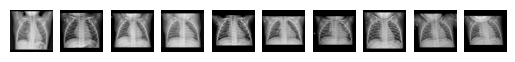

In [23]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    plt.axis("off")

plt.show()

_______________________________________________________________________________________________________________________________________________________

# 3. Preprocessing

Ici nous convertissons le format *int* des pixels de nos images en format *float32*, pour ensuite normaliser nos données (division par 255)

In [ ]:
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

display(X_train.shape)
display(X_test.shape)

(5216, 224, 224, 3)

(624, 224, 224, 3)

_______________________________________________________________________________________________________________________________________________________

# 4. Modélisation

### a. Importation du modèle **DenseNet121**, paramétrage, et compilation

Nous créons le modèle sur la base du modèle pré-entraîné **DenseNet121**. Ce dernier est très utilisé dans le domaine médical, notamment dans la détection de maladie pulmonaires. 

Nous l'importons avec ses *poids pré-entraînés* (sur *ImageNet*), c'est pourquoi nous avons dû précédemment normaliser nos données avec une certaine moyenne et certain écart-type, les mêmes que lors de l'entraînement initial du modèle. 

Nous n'utilisons pas sa dernière couche (*include-top = False*) afin d'ajouter les couches (*model_outputs*) qui nous intéresse pour le résultat que nous recherchons.

In [31]:

input_shape = (224, 224, 3)
inputs = Input(shape=input_shape)

# Importation du modèle DenseNet121 avec les poids pré-entraîné d'ImageNet, et en excluant la dernière couche (include-top=False)
base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=inputs)

# Gel des couches du modèle pré-entraîné
base_model.trainable = False

model_outputs = base_model.output
model_outputs = GlobalAveragePooling2D()(model_outputs)
model_outputs = Dense(1, activation='sigmoid')(model_outputs)

model = Model(inputs=inputs, outputs = model_outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


### b. Résumé du modèle

Nous pouvons voir toutes les couches de notre modèle. Initialement, il ne prend pas en compte les paramètres des couches gelées.

In [33]:
# model.summary()

# 5. Mise en place du MLFlow

# 6. Entraînement du modèle

# 7. Evaluation du modèle

### a. Evaluation de la précision

### b. Matrice de confusion

### c. Courbe de vérification de l'overfitting

# 8. Prédiction